In [1]:
def make_sig_mtrx(fly,parallel = True):
    
    def get_signal_dict(fly):
        """merge the signals from the nnls fits and the fly_record file into a single dictionary"""
        import h5py
        import cPickle
        import numpy as np
        fly_path = fly.fly_path
        muscle_data_file = fly_path+'nnls_fits_no_bk_dF_F.cpkl'
        fly_record_file = fly_path+'fly_record.hdf5'
        signal_dict = dict()
        fi = open(muscle_data_file,'rb')
        muscle_data = cPickle.load(fi)
        fi.close()
        for mu,sig in zip(muscle_data['muscles'],muscle_data['fits']):
            signal_dict[mu] = sig
        hf = h5py.File(fly_record_file,'r')
        exp_record = hf['experiments'].values()[0]
        for key in exp_record['tiff_data']['axon_framebase'].keys():
            signal_dict[key] = np.array(exp_record['tiff_data']['axon_framebase'][key])
        hf.close()
        return signal_dict

    import group_data as gd
    from scipy.interpolate import griddata
    import numpy as np
    import flylib
    

    sigs = get_signal_dict(fly)#fly_dict['sigs']
    fly_path = fly.fly_path#fly_dict['fly_path']
    trials = flylib.idx_by_thresh(sigs['StimCond'],-0.0)
    exp_name = fly.list_expmnts()[0]
    signal_mtrxs = dict()
    
    xi = np.linspace(0,23,1150)
    
    ##########
    ##### Motion stim
    ##########
    for key in sigs:
        signal_mtrxs[key] = list()
    
    signal_mtrxs['trial_cond'] = list()
    signal_mtrxs['fly_num'] = list()
    signal_mtrxs['exp_names'] = list()
    signal_mtrxs['trial_time'] = list()
    
    for trial in trials:
        try:
            cond = gd.decode_map[exp_name](sigs['StimCond'][trial])
            t0 = sigs['times'][trial][0]
            tn = sigs['times'][trial][-1]
            
            signal_mtrxs['trial_time'].append(np.array([t0,tn]))
                                               
            times = sigs['times'][trial] - sigs['times'][trial[0]]
            
            #signal_mtrxs['fly_num'].append(fly.fly_num)
            signal_mtrxs['trial_cond'].append(cond)
            signal_mtrxs['fly_num'].append(fly.fly_num)
            signal_mtrxs['exp_names'].append(exp_name)
            for skey in sigs.keys():#['wb_period','wb_frequency','strobe_time','Ph0','Ph1','Ph2','Ph3','StimCond']:
                resamp = griddata(times,np.array(sigs[skey])[trial],xi,method = 'linear')
                signal_mtrxs[skey].append(resamp)
        except ValueError:
            print 'ValueError'
    ##########
    ##### Stripe fixation
    ##########
    stfix = flylib.idx_by_thresh(sigs['StimCond']*-1,0.5)[0]
    t0 = sigs['times'][stfix][0]
    tn = sigs['times'][stfix][-1]
    while ((t0+23.5) < tn):
        trial = np.squeeze(np.where((sigs['times'] > t0) & (sigs['times'] < (t0+23))))
        try:
            cond = 'stripe_fix'
            times = sigs['times'][trial] - sigs['times'][trial[0]]
            #signal_mtrxs['fly_num'].append(fly.fly_num)
            signal_mtrxs['trial_cond'].append(cond)
            signal_mtrxs['fly_num'].append(fly.fly_num)
            signal_mtrxs['exp_names'].append(exp_name)
            signal_mtrxs['trial_time'].append(np.array([t0,t0+23]))
            for skey in sigs.keys():
                resamp = griddata(times,np.array(sigs[skey])[trial],xi,method = 'linear')
                signal_mtrxs[skey].append(resamp)
            t0 += 23
        except ValueError:
            print 'ValueError'
    ##########
    ##### Flight starts
    ##########
    fsig = np.array(sigs['wb_frequency'])
    #fsig = hstack((fsig,[0,0]))
    epoch_times = [(sigs['times'][ep[0]]-5,
                    sigs['times'][ep[0]]+18) for ep in flylib.idx_by_thresh(fsig,50) if np.shape(ep)[0]>500]
    
    trials = [np.squeeze(np.where((sigs['times'] > ep[0]) & (sigs['times'] < ep[1]))) for ep in epoch_times]
    ### need to find a better way to extract the #frames
    trials = [ep for ep in trials if (ep[-1] < len(sigs['b1']))]
    xi = np.linspace(0,23,1150)
    for trial in trials:
        try:
            cond = 'flight_starts'
            t0 = sigs['times'][trial][0]
            tn = sigs['times'][trial][-1]
            
            times = sigs['times'][trial] - sigs['times'][trial[0]]
            signal_mtrxs['trial_time'].append(np.array([t0,tn]))
            
            signal_mtrxs['trial_cond'].append(cond)
            signal_mtrxs['fly_num'].append(fly.fly_num)
            signal_mtrxs['exp_names'].append(exp_name)
            for skey in sigs.keys():
                resamp = griddata(times,np.array(sigs[skey])[trial],xi,method = 'linear')
                signal_mtrxs[skey].append(resamp)
        except ValueError:
            print 'ValueError'
            
    ##########
    ##### Flight stops
    ##########        
    epoch_times = [(sigs['times'][ep[-1]]-5,
                    sigs['times'][ep[-1]]+18) for ep in flylib.idx_by_thresh(fsig,50) if np.shape(ep)[0]>500]
    
    trials = [np.squeeze(np.where((sigs['times'] > ep[0]) & (sigs['times'] < ep[1]))) for ep in epoch_times]
    trials = [ep for ep in trials if (ep[-1] < len(sigs['b1']))]
    xi = np.linspace(0,23,1150)
    for trial in trials:
        try:
            cond = 'flight_stops'
            t0 = sigs['times'][trial][0]
            tn = sigs['times'][trial][-1]
            #print trial
            times = sigs['times'][trial] - sigs['times'][trial[0]]
            signal_mtrxs['trial_time'].append(np.array([t0,tn]))
                                               
            signal_mtrxs['trial_cond'].append(cond)
            signal_mtrxs['fly_num'].append(fly.fly_num)
            signal_mtrxs['exp_names'].append(exp_name)
            for skey in sigs.keys():
                resamp = griddata(times,np.array(sigs[skey])[trial],xi,method = 'linear')
                signal_mtrxs[skey].append(resamp)
        except ValueError:
            print 'ValueError' 
    
    for key in signal_mtrxs:
        signal_mtrxs[key] = np.array(signal_mtrxs[key])
    
    if parallel:
        import cPickle 
        f = open(fly.fly_path + 'nnls_fits_no_bk_dF_F_sig_mtrx.cpkl','wb')
        cPickle.dump(signal_mtrxs,f)
        f.close()
    else:
        return signal_mtrxs

In [2]:
import group_data as gd

In [3]:
%pylab inline
%config InlineBackend.figure_format = 'svg'

Populating the interactive namespace from numpy and matplotlib


In [4]:
flylist = gd.get_update_list(swarms = gd.swarms.values(),
                             file_name = 'nnls_fits_no_bk_dF_F_sig_mtrx.cpkl',
                             replace = True)

In [5]:
#parallize accross flies
from IPython.parallel import Client
clients = Client() 
clients.block = True
print clients.ids
v = clients[:]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


In [6]:
v.map(make_sig_mtrx,flylist)

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [227]:
freqsig = np.array(expmnt['tiff_data']['axon_framebase']['wb_frequency'])
times = np.array(expmnt['tiff_data']['axon_framebase']['times'])

In [21]:
gd.swarms

{'GMR10A12': <flylib.NetSquadron at 0x7fbc1cab2dd0>,
 'GMR10A12_GFP': <flylib.NetSquadron at 0x7fbc1c624290>,
 'GMR22H05': <flylib.NetSquadron at 0x7fbc1fc59f50>,
 'GMR22H05_GFP': <flylib.NetSquadron at 0x7fbc1c61ce90>,
 'GMR22H05_pr': <flylib.NetSquadron at 0x7fbc1c61c210>,
 'GMR22H05_prc': <flylib.NetSquadron at 0x7fbc1c61c6d0>,
 'GMR29E05': <flylib.NetSquadron at 0x7fbc1cab2610>,
 'GMR29E05_GFP': <flylib.NetSquadron at 0x7fbc1c6209d0>,
 'GMR31E10': <flylib.NetSquadron at 0x7fbc1caa3d90>,
 'GMR31E10_GFP': <flylib.NetSquadron at 0x7fbc1c620590>,
 'GMR39E01': <flylib.NetSquadron at 0x7fbc1caa3250>,
 'GMR39E01_GFP': <flylib.NetSquadron at 0x7fbc1c624810>,
 'GMR74F03': <flylib.NetSquadron at 0x7fbc1c618b90>,
 'GMR74F03_GFP': <flylib.NetSquadron at 0x7fbc1c620e10>,
 'GMR75B06': <flylib.NetSquadron at 0x7fbc1c618450>,
 'GMR75B06_GFP': <flylib.NetSquadron at 0x7fbc1c6244d0>}

In [17]:
os.listdir(fly.fly_path)

['spectral_data_freq.cpkl',
 'resampled_sequences.hdf5',
 'epoch_data.cpkl',
 'genotype.txt',
 'nnls_fits_no_bk_dF_F_corr_data.cpkl',
 'nnls_fits_no_bk_dF_F.cpkl',
 'spectral_data_rwing.cpkl',
 'sf_cov_images.cpkl',
 'basis_fits.cpkl',
 'nnls_fits_no_bk_dF_F_sigs.cpkl',
 'nnls_fits_no_bk_dF_F_sig_mtrx.cpkl',
 'fly_record.hdf5']

In [72]:
decode = dict()
[decode.update({i:'pth_roll_%s'%p}) for i,p in enumerate(range(0,360,30))]
decode.update({12:'pth_roll_multipole'})
decode.update({13:'pth_roll_phsrndm'})

In [73]:
decode

{0: 'pth_roll_0',
 1: 'pth_roll_30',
 2: 'pth_roll_60',
 3: 'pth_roll_90',
 4: 'pth_roll_120',
 5: 'pth_roll_150',
 6: 'pth_roll_180',
 7: 'pth_roll_210',
 8: 'pth_roll_240',
 9: 'pth_roll_270',
 10: 'pth_roll_300',
 11: 'pth_roll_330',
 12: 'pth_roll_multipole',
 13: 'pth_roll_phsrndm'}

In [76]:
val = np.around(np.mean((cond_data[cond_data>0.5]-1)*len(decode)*9))

NameError: name 'cond_data' is not defined

In [79]:
smtrx = make_sig_mtrx(gd.swarms['GMR22H05_prc'].flies[0])

KeyError: u'step_ptch_roll_ctrl'

In [123]:
fly = gd.swarms['GMR22H05_prc'].flies[0]

In [124]:
expmnt = fly.get_expmnt('step_ptch_roll_ctrl')

In [125]:
freqsig = np.array(expmnt['tiff_data']['axon_framebase']['wb_frequency'])
times = np.array(expmnt['tiff_data']['axon_framebase']['times'])
stim_cond = np.array(expmnt['tiff_data']['axon_framebase']['StimCond'])

In [126]:
import flylib

In [127]:
trials = flylib.idx_by_thresh(stim_cond,0.01)

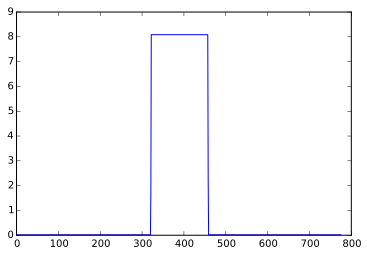

In [128]:
plot(stim_cond[trials[4]])

In [129]:
reload(gd)

<module 'group_data' from '/media/analysis-code/flight-muscles/src/group_data.pyc'>

In [131]:
x = list()
for trial in trials:
    x.append(gd.decode_cond_pitch_roll_ctrl(stim_cond[trial]))

{'pth_roll_0',
 'pth_roll_120',
 'pth_roll_150',
 'pth_roll_180',
 'pth_roll_210',
 'pth_roll_240',
 'pth_roll_270',
 'pth_roll_30',
 'pth_roll_300',
 'pth_roll_330',
 'pth_roll_60',
 'pth_roll_90',
 'pth_roll_multipole',
 'pth_roll_phsrndm'}